
# Tesla Stock Forecasting — ARIMA/SARIMA vs Multivariate LSTM (Full Notebook)

**Contents:**
1. Setup & configuration
2. Load data (expects `Date,Open,High,Low,Close,Adj Close,Volume`)
3. Feature engineering (technical indicators)
4. Chronological split (configurable)
5. ARIMA/SARIMA (univariate Close)
6. Multivariate LSTM (Open,High,Low,Close,Volume + technicals)
7. Forecast future trends (6–12 months) with intervals (ARIMA CI + LSTM MC Dropout)
8. Metrics, plots, and interpretation

> Edit the `DATA_PATH` cell to point at your CSV file, then run the notebook cells sequentially.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Install required packages (uncomment and run if needed)
# !pip install pandas numpy matplotlib scikit-learn pmdarima tensorflow statsmodels nbformat

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# optional imports
AUTO_ARIMA_AVAILABLE = True
try:
    from pmdarima import auto_arima
except Exception:
    AUTO_ARIMA_AVAILABLE = False

TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
except Exception:
    TF_AVAILABLE = False

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.random.seed(42)
print('Environment ready. TensorFlow available:', TF_AVAILABLE, 'pmdarima available:', AUTO_ARIMA_AVAILABLE)


Environment ready. TensorFlow available: True pmdarima available: False


In [14]:

# ==== CONFIG: edit these paths and parameters ====
DATA_PATH = '/content/drive/MyDrive/week11/data/raw/TSLA.csv'   # <-- set this to your CSV file path
DATE_COL = 'Date'
TARGET_COL = 'Close'

# Chronological split (edit as needed)
TRAIN_START = '2015-01-01'
TRAIN_END   = '2023-12-31'
TEST_START  = '2024-01-01'
TEST_END    = '2025-12-31'

# SARIMA toggle & seasonality period (m)
USE_SEASONAL = False
M_SEASONAL = 5

# LSTM hyperparameters (multivariate)
LOOKBACK = 60
LSTM_UNITS = 64
LSTM_DROPOUT = 0.2
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5
LR = 1e-3

# Forecast horizon for Task 3 (business days; ~126 for 6 months, ~252 for 12 months)
FORECAST_HORIZON = 252

# MC Dropout runs for LSTM uncertainty (for Task 3)
N_MC_SAMPLES = 100

USE_TECHNICALS = True  # add SMAs, EMAs, RSI, MACD to LSTM features


In [15]:
# Utilities: load, split, evaluate, helpers
from sklearn.linear_model import LinearRegression
from typing import Tuple

def load_df(path: str, date_col: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).set_index(date_col)
    df = df.asfreq('B')  # business-day frequency
    df = df.ffill().bfill()
    return df

def chronological_split_indexed(s: pd.Series, train_start, train_end, test_start, test_end):
    train = s.loc[train_start:train_end]
    test  = s.loc[test_start:test_end]
    if len(train) == 0 or len(test) == 0:
        raise ValueError('Train/test slice empty; adjust dates.')
    return train, test

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # Calculate MSE
    rmse = np.sqrt(mse) # Calculate RMSE
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE%': mape}

def summarize_trend_and_uncertainty(fc_mean: np.ndarray, lower: np.ndarray, upper: np.ndarray):
    x = np.arange(len(fc_mean)).reshape(-1,1)
    lr = LinearRegression().fit(x, fc_mean.reshape(-1,1))
    slope = float(lr.coef_[0,0])
    widths = upper - lower
    start_w = float(np.mean(widths[: max(1, len(widths)//6) ]))
    end_w   = float(np.mean(widths[- max(1, len(widths)//6) :]))
    widen_rate = (end_w - start_w) / (start_w + 1e-8)
    return {'slope': slope, 'start_width': start_w, 'end_width': end_w, 'widen_rate': widen_rate}

def plot_with_bands(history_idx, history_vals, fc_idx, mean_vals, lower_vals, upper_vals, title):
    plt.figure(figsize=(10,4))
    plt.plot(history_idx, history_vals, label='History')
    plt.plot(fc_idx, mean_vals, label='Forecast (mean)')
    plt.fill_between(fc_idx, lower_vals, upper_vals, alpha=0.2, label='Interval')
    plt.title(title)
    plt.xlabel('Date'); plt.ylabel('Close')
    plt.legend(); plt.tight_layout(); plt.show()

In [16]:

# Load your CSV
df = load_df(DATA_PATH, DATE_COL)
print('Data loaded:', df.shape)
display(df.head())
display(df.describe().T)


Data loaded: (2631, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2015-07-01,17.94333267211914,18.174667358398438,17.856666564941406,18.073999404907227,31518000
2015-07-02,18.667999267578125,18.829999923706055,18.220666885375977,18.68000030517578,107458500
2015-07-03,18.667999267578125,18.829999923706055,18.220666885375977,18.68000030517578,107458500
2015-07-06,18.648000717163086,18.779333114624023,18.420000076293945,18.591999053955078,61828500
2015-07-07,17.858667373657227,18.34666633605957,17.384666442871094,18.333332061767578,91576500


,count,unique,top,freq
Close,2631,2482,14.433333396911621,3
High,2631,2428,198.60000610351562,4
Low,2631,2447,14.333333015441895,4
Open,2631,2429,20.133333206176758,4
Volume,2631,2525,148949700,2


In [17]:
# Feature engineering for LSTM: ensure required columns exist
base_cols = ['Close','Open','High','Low','Volume']
for c in base_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

fe = df.copy()

# Convert 'Close' column to numeric, coercing errors
fe['Close'] = pd.to_numeric(fe['Close'], errors='coerce')

if USE_TECHNICALS:
    # Moving averages
    for w in [5,10,20]:
        fe[f'SMA_{w}'] = fe['Close'].rolling(w).mean()
    # EMAs
    for w in [12,26]:
        fe[f'EMA_{w}'] = fe['Close'].ewm(span=w, adjust=False).mean()
    # RSI (14)
    delta = fe['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain/(loss + 1e-8)
    fe['RSI_14'] = 100 - (100/(1+rs))
    # MACD & signal
    ema12 = fe['Close'].ewm(span=12, adjust=False).mean()
    ema26 = fe['Close'].ewm(span=26, adjust=False).mean()
    fe['MACD'] = ema12 - ema26
    fe['MACD_Signal'] = fe['MACD'].ewm(span=9, adjust=False).mean()

fe = fe.dropna()
print('Feature-engineered data shape:', fe.shape)
display(fe.head())

Feature-engineered data shape: (2612, 13)


,Close,High,Low,Open,Volume,SMA_5,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,MACD,MACD_Signal
Date,,,,,,,,,,,,,
2015-07-28,17.654667,17.69333267211914,16.78933334350586,17.049999237060547,58437000,17.577467,17.812133,17.828167,17.707792,17.801795,56.522890,-0.094003,-0.047091
2015-07-29,17.587999,17.859333038330078,17.46666717529297,17.618000030517578,41851500,17.523466,17.816667,17.810400,17.689363,17.785958,54.007044,-0.096596,-0.056992
2015-07-30,17.785999,17.79599952697754,17.474000930786133,17.512666702270508,30519000,17.518000,17.817400,17.766300,17.704230,17.785961,55.068994,-0.081731,-0.061940
2015-07-31,17.743334,17.957332611083984,17.674667358398438,17.84000015258789,33339000,17.527866,17.760666,17.720067,17.710246,17.782804,52.733258,-0.072558,-0.064063
2015-08-03,17.332666,17.78066635131836,17.13800048828125,17.752666473388672,38302500,17.620933,17.612200,17.654300,17.652157,17.749460,46.259588,-0.097303,-0.070711


In [18]:

# Univariate target for ARIMA
target = fe[TARGET_COL]
train_y, test_y = chronological_split_indexed(target, TRAIN_START, TRAIN_END, TEST_START, TEST_END)
print('Train len:', len(train_y), 'Test len:', len(test_y))

# LSTM features: Close first then others + technicals
feature_cols = [c for c in ['Close','Open','High','Low','Volume'] if c in fe.columns]
extra_cols = [c for c in fe.columns if c not in feature_cols]
feature_cols = feature_cols + extra_cols
feat_train = fe.loc[TRAIN_START:TRAIN_END, feature_cols]
feat_test  = fe.loc[TEST_START:TEST_END,  feature_cols]
print('LSTM feature columns (sample):', feature_cols[:10], '... total:', len(feature_cols))
display(feat_train.head())


Train len: 2199 Test len: 413
LSTM feature columns (sample): ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26'] ... total: 13


,Close,Open,High,Low,Volume,SMA_5,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,MACD,MACD_Signal
Date,,,,,,,,,,,,,
2015-07-28,17.654667,17.049999237060547,17.69333267211914,16.78933334350586,58437000,17.577467,17.812133,17.828167,17.707792,17.801795,56.522890,-0.094003,-0.047091
2015-07-29,17.587999,17.618000030517578,17.859333038330078,17.46666717529297,41851500,17.523466,17.816667,17.810400,17.689363,17.785958,54.007044,-0.096596,-0.056992
2015-07-30,17.785999,17.512666702270508,17.79599952697754,17.474000930786133,30519000,17.518000,17.817400,17.766300,17.704230,17.785961,55.068994,-0.081731,-0.061940
2015-07-31,17.743334,17.84000015258789,17.957332611083984,17.674667358398438,33339000,17.527866,17.760666,17.720067,17.710246,17.782804,52.733258,-0.072558,-0.064063
2015-08-03,17.332666,17.752666473388672,17.78066635131836,17.13800048828125,38302500,17.620933,17.612200,17.654300,17.652157,17.749460,46.259588,-0.097303,-0.070711


ARIMA test metrics: {'MAE': 63.74538970762336, 'RMSE': np.float64(78.91082644004467), 'MAPE%': np.float64(24.22996943945748)}


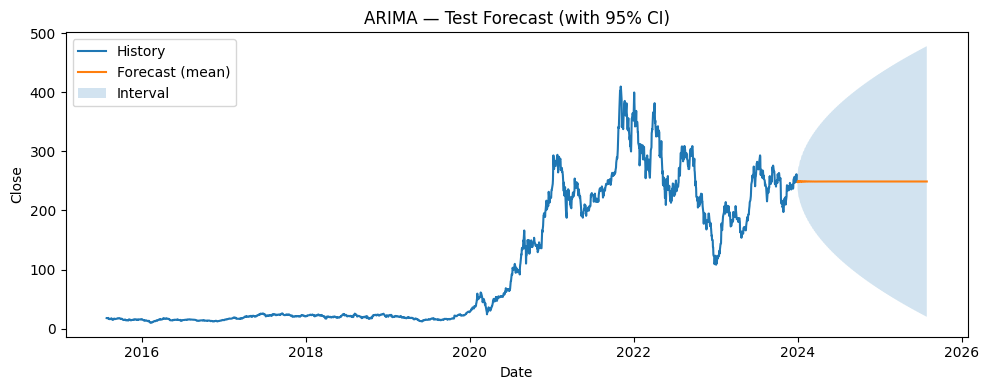

In [19]:

# ARIMA / SARIMA fit and test-set forecast (univariate Close)
h_test = len(test_y)

if AUTO_ARIMA_AVAILABLE:
    print('Using pmdarima.auto_arima for ARIMA/SARIMA selection...')
    arima = auto_arima(train_y, seasonal=USE_SEASONAL, m=(M_SEASONAL if USE_SEASONAL else 1),
                       trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    arima_fc_test = arima.predict(n_periods=h_test)
    try:
        res = arima.arima_res_
        pred = res.get_forecast(steps=h_test)
        ci = pred.conf_int(alpha=0.05)
        arima_lower_test = ci.iloc[:,0].values
        arima_upper_test = ci.iloc[:,1].values
    except Exception:
        resid_std = np.std(arima.resid())
        arima_lower_test = arima_fc_test - 1.96*resid_std
        arima_upper_test = arima_fc_test + 1.96*resid_std
else:
    from statsmodels.tsa.arima.model import ARIMA
    best_aic = np.inf; best_fit=None
    for p in [0,1,2,3]:
        for d in [0,1,2]:
            for q in [0,1,2]:
                try:
                    fit = ARIMA(train_y, order=(p,d,q)).fit()
                    if fit.aic < best_aic:
                        best_aic = fit.aic; best_fit = fit
                except Exception:
                    continue
    if best_fit is None:
        raise RuntimeError('ARIMA grid search failed.')
    pred = best_fit.get_forecast(steps=h_test)
    arima_fc_test = pred.predicted_mean.values
    ci = pred.conf_int(alpha=0.05)
    arima_lower_test = ci.iloc[:,0].values
    arima_upper_test = ci.iloc[:,1].values

arima_metrics_test = evaluate(test_y.values, arima_fc_test)
print('ARIMA test metrics:', arima_metrics_test)

plot_with_bands(train_y.index, train_y.values, test_y.index, arima_fc_test, arima_lower_test, arima_upper_test,
                'ARIMA — Test Forecast (with 95% CI)')


X_train shape: (2139, 60, 13) y_train shape: (2139, 1)
LSTM trained.
LSTM test metrics: {'MAE': 15.568387109758199, 'RMSE': np.float64(20.091940857885664), 'MAPE%': np.float64(5.9544828222181945)}


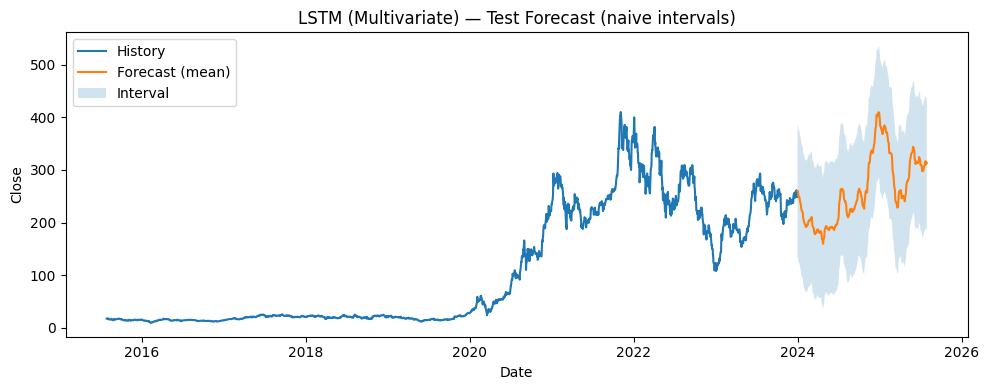

In [20]:

if not TF_AVAILABLE:
    raise RuntimeError('TensorFlow not available. Install tensorflow or tensorflow-cpu.')

# Scale features jointly (fit scaler on train features)
scaler = MinMaxScaler(feature_range=(0,1))
train_vals = feat_train.values
test_vals = feat_test.values
scaler.fit(train_vals)
train_scaled = scaler.transform(train_vals)
test_scaled  = scaler.transform(test_vals)

# Create supervised windows for training (multivariate)
def create_supervised_multivar(arr, lookback):
    X, y = [], []
    for i in range(lookback, arr.shape[0]):
        X.append(arr[i-lookback:i, :])
        y.append(arr[i, 0])  # predict Close (first column)
    return np.array(X), np.array(y).reshape(-1,1)

X_train, y_train = create_supervised_multivar(train_scaled, LOOKBACK)
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(LOOKBACK, X_train.shape[2]), return_sequences=False),
    Dropout(LSTM_DROPOUT),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1,
                    shuffle=False, callbacks=[es], verbose=0)
print('LSTM trained.')

# Forecast on test set using recursive strategy (feeding predictions)
history_seq = train_scaled.copy()
preds_scaled = []
for i in range(test_scaled.shape[0]):
    window = history_seq[-LOOKBACK:, :].reshape(1, LOOKBACK, -1)
    yhat = model.predict(window, verbose=0)[0,0]
    preds_scaled.append(yhat)
    # append new row: replace Close (col 0) with predicted scaled value, keep other features from test row
    new_row = test_scaled[i].copy()
    new_row[0] = yhat
    history_seq = np.vstack([history_seq, new_row])

# inverse scale predicted closes
inv_template = np.zeros((len(preds_scaled), train_scaled.shape[1]))
inv_template[:,0] = preds_scaled
lstm_fc_test = scaler.inverse_transform(inv_template)[:,0]

lstm_metrics_test = evaluate(test_y.values, lstm_fc_test)
print('LSTM test metrics:', lstm_metrics_test)

plot_with_bands(train_y.index, train_y.values, test_y.index, lstm_fc_test,
                lstm_fc_test - 1.96*np.std(lstm_fc_test), lstm_fc_test + 1.96*np.std(lstm_fc_test),
                'LSTM (Multivariate) — Test Forecast (naive intervals)')


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


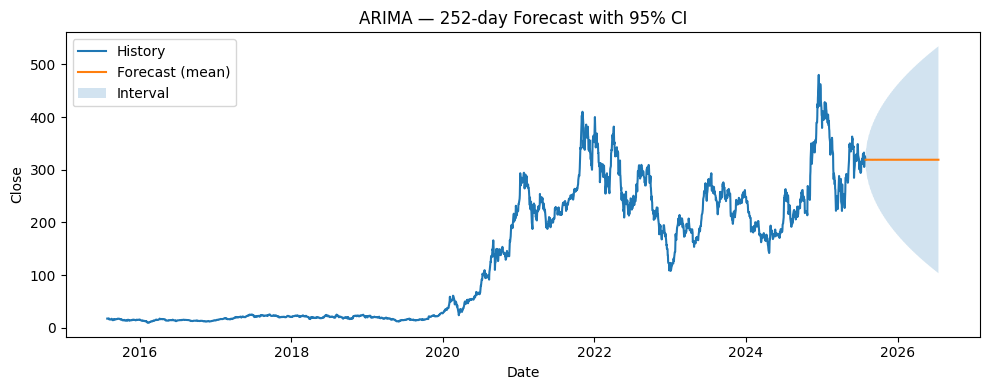

ARIMA summary: {'slope': 9.0632980003632e-07, 'start_width': 119.14331710565938, 'end_width': 412.72863055023663, 'widen_rate': 2.464135803433917}
Univariate LSTM trained for future MC forecasting.


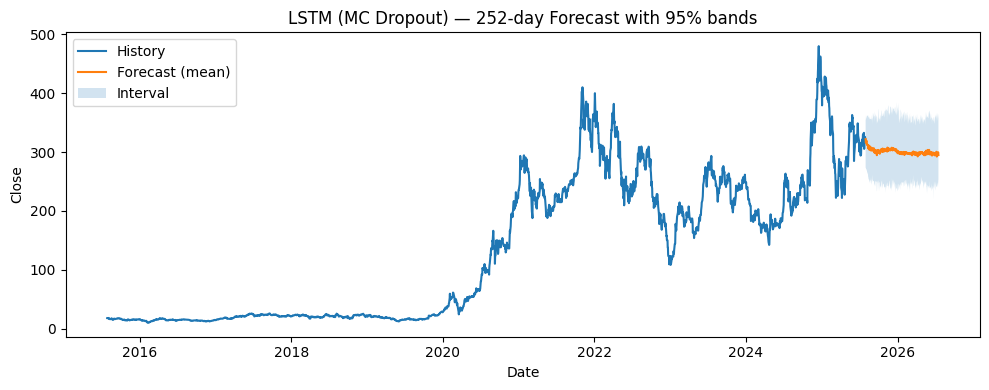

LSTM summary: {'slope': -0.04273593424993338, 'start_width': 105.28876409870047, 'end_width': 118.39481490124022, 'widen_rate': 0.12447720242027939}


In [21]:

# ---- Task 3: Forecast future N business days ----
from pandas.tseries.offsets import BDay

last_date = fe.index[-1]
future_index = pd.bdate_range(start=last_date + BDay(1), periods=FORECAST_HORIZON)

# ARIMA on full history and forecast with CI
if AUTO_ARIMA_AVAILABLE:
    arima_full = auto_arima(fe[TARGET_COL], seasonal=USE_SEASONAL, m=(M_SEASONAL if USE_SEASONAL else 1),
                            trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    arima_mean_future = arima_full.predict(n_periods=FORECAST_HORIZON)
    try:
        res = arima_full.arima_res_
        pred = res.get_forecast(steps=FORECAST_HORIZON)
        ci = pred.conf_int(alpha=0.05)
        arima_lower_future = ci.iloc[:,0].values
        arima_upper_future = ci.iloc[:,1].values
    except Exception:
        resid_std = np.std(arima_full.resid())
        arima_lower_future = arima_mean_future - 1.96*resid_std
        arima_upper_future = arima_mean_future + 1.96*resid_std
else:
    from statsmodels.tsa.arima.model import ARIMA
    best_aic = np.inf; best_fit=None
    for p in [0,1,2,3]:
        for d in [0,1,2]:
            for q in [0,1,2]:
                try:
                    fit = ARIMA(fe[TARGET_COL], order=(p,d,q)).fit()
                    if fit.aic < best_aic:
                        best_aic = fit.aic; best_fit = fit
                except Exception:
                    continue
    if best_fit is None:
        raise RuntimeError('ARIMA grid search failed.')
    pred = best_fit.get_forecast(steps=FORECAST_HORIZON)
    arima_mean_future = pred.predicted_mean.values
    ci = pred.conf_int(alpha=0.05)
    arima_lower_future = ci.iloc[:,0].values
    arima_upper_future = ci.iloc[:,1].values

plot_with_bands(fe.index, fe[TARGET_COL].values, future_index, arima_mean_future, arima_lower_future, arima_upper_future,
                f'ARIMA — {FORECAST_HORIZON}-day Forecast with 95% CI')
print('ARIMA summary:', summarize_trend_and_uncertainty(arima_mean_future, arima_lower_future, arima_upper_future))

# LSTM (Univariate Close) with MC Dropout for uncertainty
if not TF_AVAILABLE:
    raise RuntimeError('TensorFlow not available for LSTM future forecasting.')

# Prepare univariate scaled sequence
close_vals = fe[TARGET_COL].values.astype(float)
min_v, max_v = close_vals.min(), close_vals.max()
def scale(x): return (x - min_v) / (max_v - min_v + 1e-9)
def inv_scale(x): return x*(max_v - min_v + 1e-9) + min_v

seq = scale(close_vals)
# build training windows on full data
X_full = []
for i in range(LOOKBACK, len(seq)):
    X_full.append(seq[i-LOOKBACK:i])
X_full = np.array(X_full).reshape(-1, LOOKBACK, 1)

# train a small univariate LSTM on the full sequence
uni_model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(LOOKBACK,1), return_sequences=False),
    Dropout(LSTM_DROPOUT),
    Dense(1)
])
uni_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse')
uni_model.fit(X_full, seq[LOOKBACK:].reshape(-1,1), epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, shuffle=False, callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True)], verbose=0)
print('Univariate LSTM trained for future MC forecasting.')

# MC Dropout forecasts
mc_paths = []
for mc in range(N_MC_SAMPLES):
    hist = seq.copy().tolist()
    path = []
    for t in range(FORECAST_HORIZON):
        window = np.array(hist[-LOOKBACK:]).reshape(1, LOOKBACK, 1)
        yhat = float(uni_model(window, training=True).numpy()[0,0])  # enable dropout at inference
        path.append(yhat)
        hist.append(yhat)
    mc_paths.append(path)

mc_paths = np.array(mc_paths)
mean_scaled = mc_paths.mean(axis=0)
lower_scaled = np.quantile(mc_paths, 0.025, axis=0)
upper_scaled = np.quantile(mc_paths, 0.975, axis=0)

lstm_mean_future = inv_scale(mean_scaled)
lstm_lower_future = inv_scale(lower_scaled)
lstm_upper_future = inv_scale(upper_scaled)

plot_with_bands(fe.index, fe[TARGET_COL].values, future_index, lstm_mean_future, lstm_lower_future, lstm_upper_future,
                f'LSTM (MC Dropout) — {FORECAST_HORIZON}-day Forecast with 95% bands')
print('LSTM summary:', summarize_trend_and_uncertainty(lstm_mean_future, lstm_lower_future, lstm_upper_future))


In [22]:

# Side-by-side metrics and automated interpretation for Task 3 forecasts
import pandas as pd
arima_summary = summarize_trend_and_uncertainty(arima_mean_future, arima_lower_future, arima_upper_future)
lstm_summary  = summarize_trend_and_uncertainty(lstm_mean_future, lstm_lower_future, lstm_upper_future)

print('\n=== Automated Interpretation ===\n')
def interpret(summary, label):
    slope = summary['slope']
    trend = 'upward' if slope>0 else ('downward' if slope<0 else 'flat')
    widen = summary['widen_rate']
    widen_note = 'widening' if widen>0.05 else ('narrowing' if widen<-0.05 else 'stable')
    print(f'[{label}] Trend: {trend} (slope={slope:.6f}), intervals are {widen_note} over the horizon.')

interpret(arima_summary, 'ARIMA/SARIMA')
interpret(lstm_summary, 'LSTM (MC Dropout)')

# Opportunities & risks (simple heuristics)
def opp_risk(mean_vals, lower_vals, upper_vals, label):
    exp_change = (mean_vals[-1] - mean_vals[0]) / (mean_vals[0]+1e-9)
    downside = (lower_vals[-1] - mean_vals[-1]) / (mean_vals[-1]+1e-9)
    upside = (upper_vals[-1] - mean_vals[-1]) / (mean_vals[-1]+1e-9)
    print(f'\n[{label}] Expected change: {exp_change*100:.2f}%. Downside tail: {downside*100:.2f}%. Upside tail: {upside*100:.2f}%')

opp_risk(arima_mean_future, arima_lower_future, arima_upper_future, 'ARIMA')
opp_risk(lstm_mean_future, lstm_lower_future, lstm_upper_future, 'LSTM')



=== Automated Interpretation ===

[ARIMA/SARIMA] Trend: upward (slope=0.000001), intervals are widening over the horizon.
[LSTM (MC Dropout)] Trend: downward (slope=-0.042736), intervals are widening over the horizon.

[ARIMA] Expected change: -0.00%. Downside tail: -67.52%. Upside tail: 67.52%

[LSTM] Expected change: -8.46%. Downside tail: -16.85%. Upside tail: 21.36%
